In [1]:
wiki_path = './零之使魔_wiki.txt'
novel_path='./零之使魔.txt'
output_dir='./output_zero/'
faiss_path=output_dir+'faiss_index'
rename_map_path=output_dir+'rename_map.json'

include_novel=False
include_title=True
max_title_len=20
min_content_len=20
max_content_len=100
chunk_overlap=10

import os,json
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

rename_map=json.load(open(rename_map_path,'r',encoding='utf-8')) if os.path.exists(rename_map_path) else {}

# 读取wiki txt，分块

successfully read novel text from  ./零之使魔.txt
successfully read wiki text from  ./零之使魔_wiki.txt


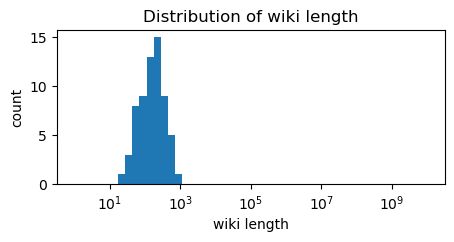

Number of wikis:  64


In [2]:
import re

with open(novel_path,'r',encoding='utf-8') as f:
    novel_text=f.read()
print('successfully read novel text from ', novel_path)

for from_name,to_name in rename_map.items():
    novel_text=novel_text.replace(from_name,to_name)

re_chapter_title=re.compile(r"^(.{1,8}章|.{1,8}篇|.{1,8}集|.{1,8}卷|后记|序)\s", flags=re.MULTILINE)
chapters = re.split(re_chapter_title, novel_text)[1:]
chapters = [chapters[i]+' '+chapters[i + 1] for i in range(0, len(chapters), 2) if len(chapters[i + 1]) > min_content_len]
chapter_titles=[chapter.split('\n')[0].strip()[:max_title_len] for chapter in chapters]
chapters=[chapter.split('\n',1)[1] for chapter in chapters]

    
with open(wiki_path,'r',encoding='utf-8') as f:
    wiki_text=f.read()

for from_name,to_name in rename_map.items():
    wiki_text=wiki_text.replace(from_name,to_name)

print('successfully read wiki text from ', wiki_path)
wiki_text=re.sub(r'^\%.*\n','',wiki_text,flags=re.MULTILINE) # remove lines start with %
re_wiki_title=re.compile(r"^(【词条】)\s", flags=re.MULTILINE) # 【词条】 XXXXXX
wikis=re.split(re_wiki_title,wiki_text)[1:]
wikis=[wikis[i]+' '+wikis[i+1] for i in range(0,len(wikis),2) if len(wikis[i+1])>min_content_len]
wiki_titles=[wiki.split('\n')[0].strip().replace('【词条】','')[:max_title_len] for wiki in wikis]
wikis=[wiki.split('\n',1)[1] for wiki in wikis]


import matplotlib.pyplot as plt
import numpy as np
if include_novel:
    plt.figure(figsize=(5, 2))
    plt.hist([len(chapter) for chapter in chapters], bins=np.logspace(0, 10, 50))
    plt.xscale('log');plt.xlabel('chapter length');plt.ylabel('count');plt.title('Distribution of chapter length');plt.show()
    print('Number of chapters: ', len(chapters))

plt.figure(figsize=(5, 2))
plt.hist([len(wiki) for wiki in wikis], bins=np.logspace(0, 10, 50))
plt.xscale('log');plt.xlabel('wiki length');plt.ylabel('count');plt.title('Distribution of wiki length');plt.show()
print('Number of wikis: ', len(wikis))


Number of documents:  208


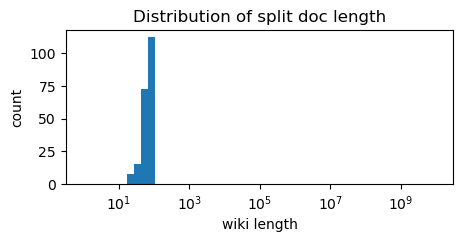

Number of docs:  208


In [3]:
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter=RecursiveCharacterTextSplitter(chunk_size=max_content_len,chunk_overlap=chunk_overlap)

documents=[]
documents+=[Document(page_content=wiki,metadata={'title':title,'type':'wiki'}) for wiki,title in zip(wikis,wiki_titles)]
if include_novel:
    documents+=[Document(page_content=chapter,metadata={'title':title,'type':'novel'}) for chapter,title in zip(chapters,chapter_titles)]
documents=text_splitter.split_documents(documents)
for doc in documents:
    if include_title:
        doc.page_content=doc.metadata['title']+'\n'+doc.page_content
    doc.page_content=doc.page_content.replace('\n',' ').strip()
documents=[doc for doc in documents if len(doc.page_content)>min_content_len]

print('Number of documents: ', len(documents))

import random
random.sample(documents,5)

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 2))
plt.hist([len(doc.page_content) for doc in documents], bins=np.logspace(0, 10, 50))
plt.xscale('log');plt.xlabel('wiki length');plt.ylabel('count');plt.title('Distribution of split doc length');plt.show()
print('Number of docs: ', len(documents))

# 建立FAISS索引

In [4]:
# import importlib;import my_faiss;importlib.reload(my_faiss)
from my_faiss import embeddings, FAISS, get_bg_hint

No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.
No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.


In [5]:
# WARNING VERY SLOW
from tqdm.auto import tqdm
import os

override_faiss_cache=True

if os.path.exists(faiss_path+'/index.faiss') and not override_faiss_cache:
    vector_store=FAISS.load_local(faiss_path, embeddings)
    print('loaded vector store from ', faiss_path)
else:
    vector_store = FAISS.from_documents(documents, embeddings)
    vector_store.save_local(faiss_path)
    print('saved vector store to ', faiss_path)

get_bg_hint.vector_store=vector_store

saved vector store to  ./output_zero/faiss_index


# 可选：将chapter summary加入到索引中

# 测试

需要人工精校wiki.txt，检查是否能索引到相关的wiki页面

In [6]:
queries=[
    '露易丝',
    '才人取出了武器',
    '才人大战约瑟夫',
    '露易丝在吵架',
    '塔巴萨和夏洛特',
]

for query in queries:
    print('query: ',query)
    print(get_bg_hint(query,max_text_len=500,k=25,show_score=True))

query:  露易丝
【露易丝 露易丝·法兰西斯·露·布朗·杜·拉·瓦利埃尔 本作女主角，作品中一般称为露易丝，有着夹杂金色的粉红长卷发、茶褐色的眼瞳（动画为桃红色）。（0.54）】
【露易丝 起初对身为贵族的身份有着很强的自觉心，拥有常人N倍的自尊心，后来受才人影响，逐渐放下这份执着，转而为才人着想。在后期已经可以对才人敞开心扉，坦诚相待。（0.38）】
【露易丝 动画第三期中为救出塔芭莎而放弃贵族身份，但被公主赏识，成为王位继承人。喜欢平贺才人。（0.36）】
【平贺才人 已与露易丝同居中。同时被书中许多女性角色爱慕著。喜欢露易丝。（0.34）】
【露易丝 的性格易怒，容易骂人，有点糊涂（跟才人比），为了小事常常生气。（0.32）】
【露易丝 在托里斯汀东北拥有领土的名门拉·瓦利埃尔公爵家的三女儿、托里斯汀魔法学院的二年级学生。（0.32）】
【安丽埃塔 小说16-17卷有欲从露易丝那里里夺取才人，羡慕著露易丝。（0.31）】
【露易丝 为露易丝配音的钉宫理惠，亦是J.C. STAFF前一部作品《灼眼的夏娜》中夏娜的声优。同时也是傲娇的著名角色之一，钉宫四萌之一（0.29）】
query:  才人取出了武器
【德鲁弗林加 在小说第十六集中为了救才人，刀身过量吸收杀手元素兄弟的魔法攻击而被毁，不过却及时把精神力转移至才人的武士刀上，在小说十九集中才人与精灵亚利对决中再度觉醒。（0.39）】
【手枪 被露易丝以“爆炸”魔法成功阻止。后来归才人所有，正式名称是SIG P226手枪， 使用9x19mm子弹。才人在与约瑟夫的战斗中丢弃。（0.35）】
【平贺才人 他的武器：智慧之剑（在小说第16卷与元素兄弟的战斗中被毁，后来作为精神转移至武士刀的德鲁弗林加在第19卷再度觉醒，后为了复活露易丝而再度牺牲，但灵魂似乎依旧存在。）（0.31）】
【平贺才人 的武器是露易丝替他买的一把剑，原本只是因为会说话好玩而买下，但后来才知那把剑是拥有知性的“智慧之剑”德鲁弗林加，那剑在过去6,000年都是由甘道夫所使用的。（0.29）】
【德鲁弗林加 才人平时用的长剑，有自我意识的智慧之剑。因为表面破烂不堪，露易丝以相当低廉的价格就买下了，并且送给才人当配剑。 被才人称作“德鲁”,自己则以“伙伴”称呼才人。很喜欢说话。但当被放入剑鞘时就不能说话，（0.29）】
query:  才人大战约

In [21]:
from my_llm import llm_chatgpt as llm

dialogue='【才人和丘鲁克在咖啡馆偷偷约会，突然露易丝进来了】\n露易丝：（气死了）\n露易丝：你你你才人你这个笨蛋在做什么啊！\n'
bg_hint=get_bg_hint(dialogue,max_text_len=1000,k=25,show_score=True)
print(bg_hint)
# llm(bg_hint+'\n【请扮演露易丝，写的有趣活泼，不要加入没有意思的套话。】\n'+dialogue)

【露易丝 的性格易怒，容易骂人，有点糊涂（跟才人比），为了小事常常生气。（0.38）】
【丘鲁克 丘鲁克·奥古斯都·菲列特利加·封·安哈尔特·泽鲁普斯特 露易丝的同学，与露易丝关系特别不好，经常取笑露易丝的魔法水平。在后期与露易丝关系有所改善。（0.38）】
【丘鲁克 她的性格:强气，表面风骚但还是很珍视自己外骚内闷？越生气越冷静 她的兴趣：玩拼图 她的特殊技能: 药草 她讨厌：下雨、露易丝 （小说后来与露易丝很要好） 她的好友：塔芭莎、露易丝（0.38）】
【平贺才人 已与露易丝同居中。同时被书中许多女性角色爱慕著。喜欢露易丝。（0.36）】
【露易丝 脸蛋无可挑剔，但因为魔法糟糕而总是被同学取笑。她的每次施法都以失败告终，因为零成功率和零属性，因此被戏称为“零之露易丝”。 是少见的“虚无”系统的魔法师，只要情绪起伏大就能蓄积大量魔力。（0.33）】
【露易丝 她喜欢的食物：可可浆果派　 她的趣味：编织（虽然说是超烂）、虐待才人（因为吃醋很生气）　 她的特技：爆炸、骑马、鞭打才人、百分百捉奸　 她的发型：桃色卷发 她的魔法属性：虚无，虚无消失后变成风属性。（0.33）】
【拉·瓦利埃尔公爵 在托里斯特因有很大的影响力，涉足军、政、商三界，与王室关系密切，动画版第十二话认可了露易丝与才人的关系，同意让露易丝嫁给才人，在罗马尼亚大圣堂做了见证。（0.29）】
【露易丝 露易丝·法兰西斯·露·布朗·杜·拉·瓦利埃尔 本作女主角，作品中一般称为露易丝，有着夹杂金色的粉红长卷发、茶褐色的眼瞳（动画为桃红色）。（0.29）】
【体现露易丝性格的语录 生气时：无路赛！无路赛！无路赛！(啰嗦啰嗦啰嗦！) 悲伤时：一小时的话，我也可以装作不知道的。 悲伤时：我呢，已经，一生都不会再笑了。（0.29）】
【零之使魔 以住宿制的特里斯汀魔法学院为舞台，作为使魔的平贺才人开始了他倍受一副主人模样的美少女魔法使露易丝打骂、调教以及疼爱，充满勇气和屈辱的令人心动的学园生活……（0.29）】
【艾丽欧诺尔·瓦利埃尔 表面上看来她对露易丝很严格，而且处处刁难，但其实她是非常疼爱露易丝，也是因为怕露易丝被人耻笑， 才用了比较强制的方式，想借此保护露易丝。否定自己嫁不出去的事实，也会像露易丝拿藤鞭教训才人，（0.28）】


In [22]:
random_context=random.choice(chapters)[:500]
print(random_context)
bg_hint=get_bg_hint(random_context,max_text_len=1000,k=25,show_score=True)
print(bg_hint)

     更新时间:2009-5-23 11:33:58 本章字数:4978

    借助蒙莫兰希的“水”魔法治愈了伤势的才人，开始听丘鲁克他们说明事情的经过。丘鲁克贺塔芭萨正在篝火的旁边烤着肉。一手拿着葡萄酒的基修似乎很开心似的在他们旁边大声说着什么。这家伙似乎现在还是怀着来旅游的心态。时刻大概是深夜两点吧，湖面上映照出两轮明月，绽开在眼前的是一幅美丽绝伦的画面。
    丘鲁克向走过来的才人问了一句“伤治好了没有”，才人虽然对败给了两人感到很不甘心，但还是由衷地对两人的绝妙配合表示佩服。
    “你们真的好强！我还以为要被你们干掉呢。”
    “算是啦，当然也不会弱。不过，胜败也是取决于时机和运气，如果你们的配合完美的话，我们可能就只有逃掉了。因为战斗的人就只有你一个。基修好像只是躲在一边发抖的样子，蒙莫兰希也只是在看。最多就只能算上露易丝的最后一击了。”
    琪尔克得意地挽起了她的长发。
    “可是。为什么你们要袭击水之精灵呢？”
    才人在篝火旁坐下，向他们问道。
    “为什么你们要保护水之精灵呢？”
    琪尔克反问了一句。一直在才人背后贴得紧紧的露易
【丘鲁克 她的性格:强气，表面风骚但还是很珍视自己外骚内闷？越生气越冷静 她的兴趣：玩拼图 她的特殊技能: 药草 她讨厌：下雨、露易丝 （小说后来与露易丝很要好） 她的好友：塔芭莎、露易丝（0.44）】
【卡托丽雅·瓦利埃尔 她同时也是第一个看出才人与露易丝关系的人，曾经在才人思乡的时候安抚过才人，并一直在暗中帮忙他们。 尽管她病弱，不过她一样也是极高明的魔法师。 动画版第四部第12话见证两人的婚礼（0.40）】
【丘鲁克 丘鲁克·奥古斯都·菲列特利加·封·安哈尔特·泽鲁普斯特 露易丝的同学，与露易丝关系特别不好，经常取笑露易丝的魔法水平。在后期与露易丝关系有所改善。（0.39）】
【平贺才人 他的身份：使魔，水精灵骑士团副团长 他的主人:露易丝、蒂法妮娅BOSS战力量消耗殆尽契约消失 他的阶级：贵族（骑士）（chevalier，实力上已达矩形级法师的力量） 他喜欢的食物：照烧汉堡（0.38）】
【里维斯拉谢尔 被称为神之心脏的最后的使魔。神之心脏疑似拥有令人不愿意接触的命运以及能力，在才人被露易丝二度召唤，约赛特召唤朱力欧时皆庆幸不是神之心脏，并为蒂法使魔为神之心脏而感到遗憾。（0